<!-- 1. Title and Introduction -->
<div>
<h1>Cefepime Resistance Predictor: Unlocking E. coli Insights</h1>
<h4>This project is to predict the resistance and susceptance of Cefepime antibiotic in E. Coli bacteria.</h4>
<p>My name is Jhanavi Dave, and this notebook is my analysis of three models- Random Forest Classifier, Logistic Regression and Gradient Boosting Models on two features- Presence/Absence and Kmers, to check for genetic mutations and sequences in the nucleotide responsible for the resistance of Cefepime (a commonly used antibiotic for E. coli).</p>
<p>In technical terms, presence/absence captures high-level genetic markers, while k-mers provide fine-grained genomic details. Combining both can improve prediction accuracy. Using multiple feature sets ensures the model is not overly reliant on one type of data, making it more robust to noise or missing information.</p>
<p>This project can be found at <a href="https://github.com/jhanavidave/Cefepime-Resistance-Predictor-Unlocking-E.-coli-Insights.git"> Cefepime Resistance Predictor: Unlocking E. coli Insights</a>
</div>

<h3>Import libraries required for data handling, model training, evaluation, and visualization.</h3>

In [1]:
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.exceptions import DataConversionWarning
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy import stats
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, balanced_accuracy_score
from scipy.stats import uniform
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

<h3>Load the datasets (presence-absence, k-mers, and labels).</h3>
<p>The load_data() function loads and processes datasets required for machine learning tasks. It reads presence/absence data (train_pa_genes, test_pa_genes) from CSV files and k-mer features (train_kmers, test_kmers) from .npy files. It also loads training labels (y_train) and genome IDs (y_train_ids, y_test_ids) from .npy files, ensuring IDs are converted to strings. Additionally, it reads gene alignment data for training and testing, converting relevant columns to the appropriate data types. The presence/absence and k-mer data are converted into NumPy arrays for compatibility with machine learning models. Finally, the function returns all loaded datasets, which are then assigned to corresponding variables for further use.</p>


In [2]:
seed = 130

def load_data():
    train_pa_genes = pd.read_csv('./data/train_test_data/train_pa_genes.csv').set_index('genome_id')
    test_pa_genes = pd.read_csv('./data/train_test_data/test_pa_genes.csv').set_index('genome_id')
    train_kmers = np.load('./data/train_test_data/train_kmers.npy', allow_pickle=True)
    test_kmers = np.load('./data/train_test_data/test_kmers.npy', allow_pickle=True)

    y_train = np.load('./data/train_test_data/y_train.npy', allow_pickle=True)
    y_train_ids = np.load('./data/train_test_data/train_ids.npy', allow_pickle=True).astype(str)
    y_test_ids = np.load('./data/train_test_data/test_ids.npy', allow_pickle=True).astype(str)

    train_genes_alignment = pd.read_csv('./data/train_test_data/train_genes.csv')
    test_genes_alignment = pd.read_csv('./data/train_test_data/test_genes.csv')
    test_genes_alignment['genome_id'] = test_genes_alignment.genome_id.astype(str)

    X_train_pa = np.array(train_pa_genes)
    X_test_pa = np.array(test_pa_genes)
    X_train_kmers = np.array(train_kmers, dtype=np.float32)
    X_test_kmers = np.array(test_kmers, dtype=np.float32)

    return train_pa_genes, test_pa_genes, train_kmers, test_kmers, train_genes_alignment, test_genes_alignment, y_train, y_train_ids, y_test_ids, X_train_pa, X_test_pa, X_train_kmers, X_test_kmers

train_pa_genes, test_pa_genes, train_kmers, test_kmers, train_genes_alignment, test_genes_alignment, y_train, y_train_ids, y_test_ids, X_train_pa, X_test_pa, X_train_kmers, X_test_kmers = load_data()

<h3>Build presence/absence matrix for training and testing</h3>
<p>The build_gene_presence_absence function constructs a presence/absence matrix for genes in a given dataset. It takes a dataset, a list of genome IDs (ids), and an optional list of gene names (gene_names). If gene_names is not provided, it extracts unique gene names from the dataset. The function creates a pivot table to count occurrences of each gene for each genome, filling missing values with zeros. It ensures all specified genes are included in the matrix, adding columns for missing genes and rows for missing genome IDs, initializing them to zero. Finally, it reorders the matrix to match the provided genome IDs and returns the completed presence/absence matrix.</p>

In [3]:
def build_gene_presence_absence(dataset, ids, gene_names=None):
    if gene_names is None:
        gene_names = dataset.res_gene.unique()

    genes_counts = (
        dataset[['genome_id', 'res_gene']]
        .assign(count=1)
        .pivot_table('count', index='genome_id', columns='res_gene')
        .fillna(0)
    )

    missing_genes = [gene for gene in gene_names if gene not in genes_counts.columns]
    missing_df = pd.DataFrame(0, index=genes_counts.index, columns=missing_genes)
    genes_counts = pd.concat([genes_counts, missing_df], axis=1)

    for gene in gene_names:
        if gene not in genes_counts.columns:
            genes_counts[gene] = 0

    genes_counts = genes_counts[gene_names]

    for genome_id in ids:
        if genome_id not in genes_counts.index:
            genes_counts.loc[genome_id] = 0

    genes_counts = genes_counts.loc[ids]

    return genes_counts

<h3>Generate k-mer features for the combined dataset</h3>
<p>Define two functions for generating k-mer features from genomic sequences. The count_kmers function takes a sequence and a k-mer size (k) as input and counts the occurrences of each k-mer (subsequence of length k) in the sequence, returning a dictionary of k-mer counts. The count_kmers_per_sample function processes a dataset containing genomic sequences grouped by a sample identifier (e.g., genome_id). It concatenates sequences for each sample, converts them to uppercase, and computes k-mer counts for each sample using the count_kmers function. The results are stored in a DataFrame, where rows represent samples, columns represent k-mers, and values represent their counts, with missing values filled with zeros. This DataFrame is returned for further analysis.</p>

In [4]:
def count_kmers(sequence, k=5):
    kmer_counts = defaultdict(int)
    for i_start in range(len(sequence) - (k - 1)):
        kmer = sequence[i_start:i_start + k]
        kmer_counts[kmer] += 1
    return kmer_counts

def count_kmers_per_sample(dataset, sample_id_col='genome_id', gene_col='ref_gene_str'):
    seq_per_sample = dataset.groupby(sample_id_col).agg({'ref_gene_str': ''.join}).reset_index()
    seq_per_sample['ref_gene_str'] = seq_per_sample['ref_gene_str'].str.upper()

    kmer_counts = {}
    for ref_name, sequence in seq_per_sample[[sample_id_col, gene_col]].to_records(index=False):
        kmer_counts[ref_name] = count_kmers(sequence)

    kmer_counts_df = pd.DataFrame(kmer_counts).fillna(0).transpose()
    return kmer_counts_df

<h3>Train Random Forest on Presence/Absence and Kmer features. Save predictions.</h3>
<p>Trained two Random Forest classifiers with 30 estimators and a maximum depth of 10, using a fixed random seed for reproducibility. The first model (rf_model_pa) is trained on presence/absence features (X_train_pa) and the second model (rf_model_kmer) is trained on k-mer features (X_train_kmers), both using the same target labels (y_train). Predictions are then made on the respective test datasets (X_test_pa and X_test_kmers). The predictions, along with the corresponding genome IDs (y_test_ids), are saved to two separate CSV files: rf_predictions_pa.csv for presence/absence predictions and rf_predictions_kmer.csv for k-mer predictions.</p>

In [5]:
rf_model_pa = RandomForestClassifier(n_estimators=20, max_depth=10, random_state=seed)
rf_model_pa.fit(X_train_pa, y_train)
rf_predictions_pa = rf_model_pa.predict(X_test_pa)

rf_model_kmer = RandomForestClassifier(n_estimators=20, max_depth=10, random_state=seed)
rf_model_kmer.fit(X_train_kmers, y_train)
rf_predictions_kmer = rf_model_kmer.predict(X_test_kmers)

pd.DataFrame({'genome_id': y_test_ids, 'predictions_pa': rf_predictions_pa}).to_csv('rf_predictions_pa.csv', index=False)
pd.DataFrame({'genome_id': y_test_ids, 'predictions_kmer': rf_predictions_kmer}).to_csv('rf_predictions_kmer.csv', index=False)

<h3>Train Logistic Regression on Presence/Absence and Kmer features. Save predictions.</h3>
<p>Trained two Logistic Regression models to predict antibiotic resistance. The first model (lr_model_pa) is trained on presence/absence features (X_train_pa), which are scaled using StandardScaler for normalization. The second model (lr_model_kmer) is trained on k-mer features (X_train_kmers). Both models use the same target labels (y_train). Predictions are made on the respective test datasets (X_test_pa and X_test_kmers), and the results, along with genome IDs (y_test_ids), are saved to two CSV files: lr_predictions_pa.csv for presence/absence predictions and lr_predictions_kmer.csv for k-mer predictions.</p>

In [6]:
lr_model_pa = LogisticRegression(max_iter=100, random_state=seed)
scaler = StandardScaler()
X_train_pa_scaled = scaler.fit_transform(X_train_pa)
X_test_pa_scaled = scaler.transform(X_test_pa)
lr_model_pa.fit(X_train_pa, y_train)
lr_predictions_pa = lr_model_pa.predict(X_test_pa)

lr_model_kmer = LogisticRegression(max_iter=100, random_state=seed)
lr_model_kmer.fit(X_train_kmers, y_train)
lr_predictions_kmer = lr_model_kmer.predict(X_test_kmers)

pd.DataFrame({'genome_id': y_test_ids, 'predictions_pa': lr_predictions_pa}).to_csv('lr_predictions_pa.csv', index=False)
pd.DataFrame({'genome_id': y_test_ids, 'predictions_kmer': lr_predictions_kmer}).to_csv('lr_predictions_kmer.csv', index=False)

c:\Users\jhana\miniconda3\envs\etbg-env\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\jhana\miniconda3\envs\etbg-env\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

<h3>Train Gradient Boosting on Presence/Absence and Kmer features. Save predictions.</h3>
<p>Trained two Gradient Boosting classifiers with 30 estimators, a learning rate of 0.1, and a maximum depth of 3, using a fixed random seed for reproducibility. The first model (gb_model_pa) is trained on presence/absence features (X_train_pa), and the second model (gb_model_kmer) is trained on k-mer features (X_train_kmers), both using the same target labels (y_train). Predictions are made on the respective test datasets (X_test_pa and X_test_kmers). The predictions, along with the corresponding genome IDs (y_test_ids), are saved to two separate CSV files: gb_predictions_pa.csv for presence/absence predictions and gb_predictions_kmer.csv for k-mer predictions.</p>

In [7]:
gb_model_pa = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_depth=3, random_state=seed)
gb_model_pa.fit(X_train_pa, y_train)
gb_predictions_pa = gb_model_pa.predict(X_test_pa)

gb_model_kmer = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_depth=3, random_state=seed)
gb_model_kmer.fit(X_train_kmers, y_train)
gb_predictions_kmer = gb_model_kmer.predict(X_test_kmers)

pd.DataFrame({'genome_id': y_test_ids, 'predictions_pa': gb_predictions_pa}).to_csv('gb_predictions_pa.csv', index=False)
pd.DataFrame({'genome_id': y_test_ids, 'predictions_kmer': gb_predictions_kmer}).to_csv('gb_predictions_kmer.csv', index=False)

<h3>Plot predictions for each model and feature type</h3>
<p>Generated a 2x3 grid of scatter plots to visualize the predictions of three machine learning models (Random Forest, Logistic Regression, and Gradient Boosting) on two feature sets (Presence/Absence and K-mers). Each subplot corresponds to a specific model and feature set combination, showing the predicted labels against genome indices. The plots are color-coded and labeled for clarity, with legends and titles indicating the model and feature type. The layout is adjusted for better visualization, and the final plots are displayed using plt.show().</p>

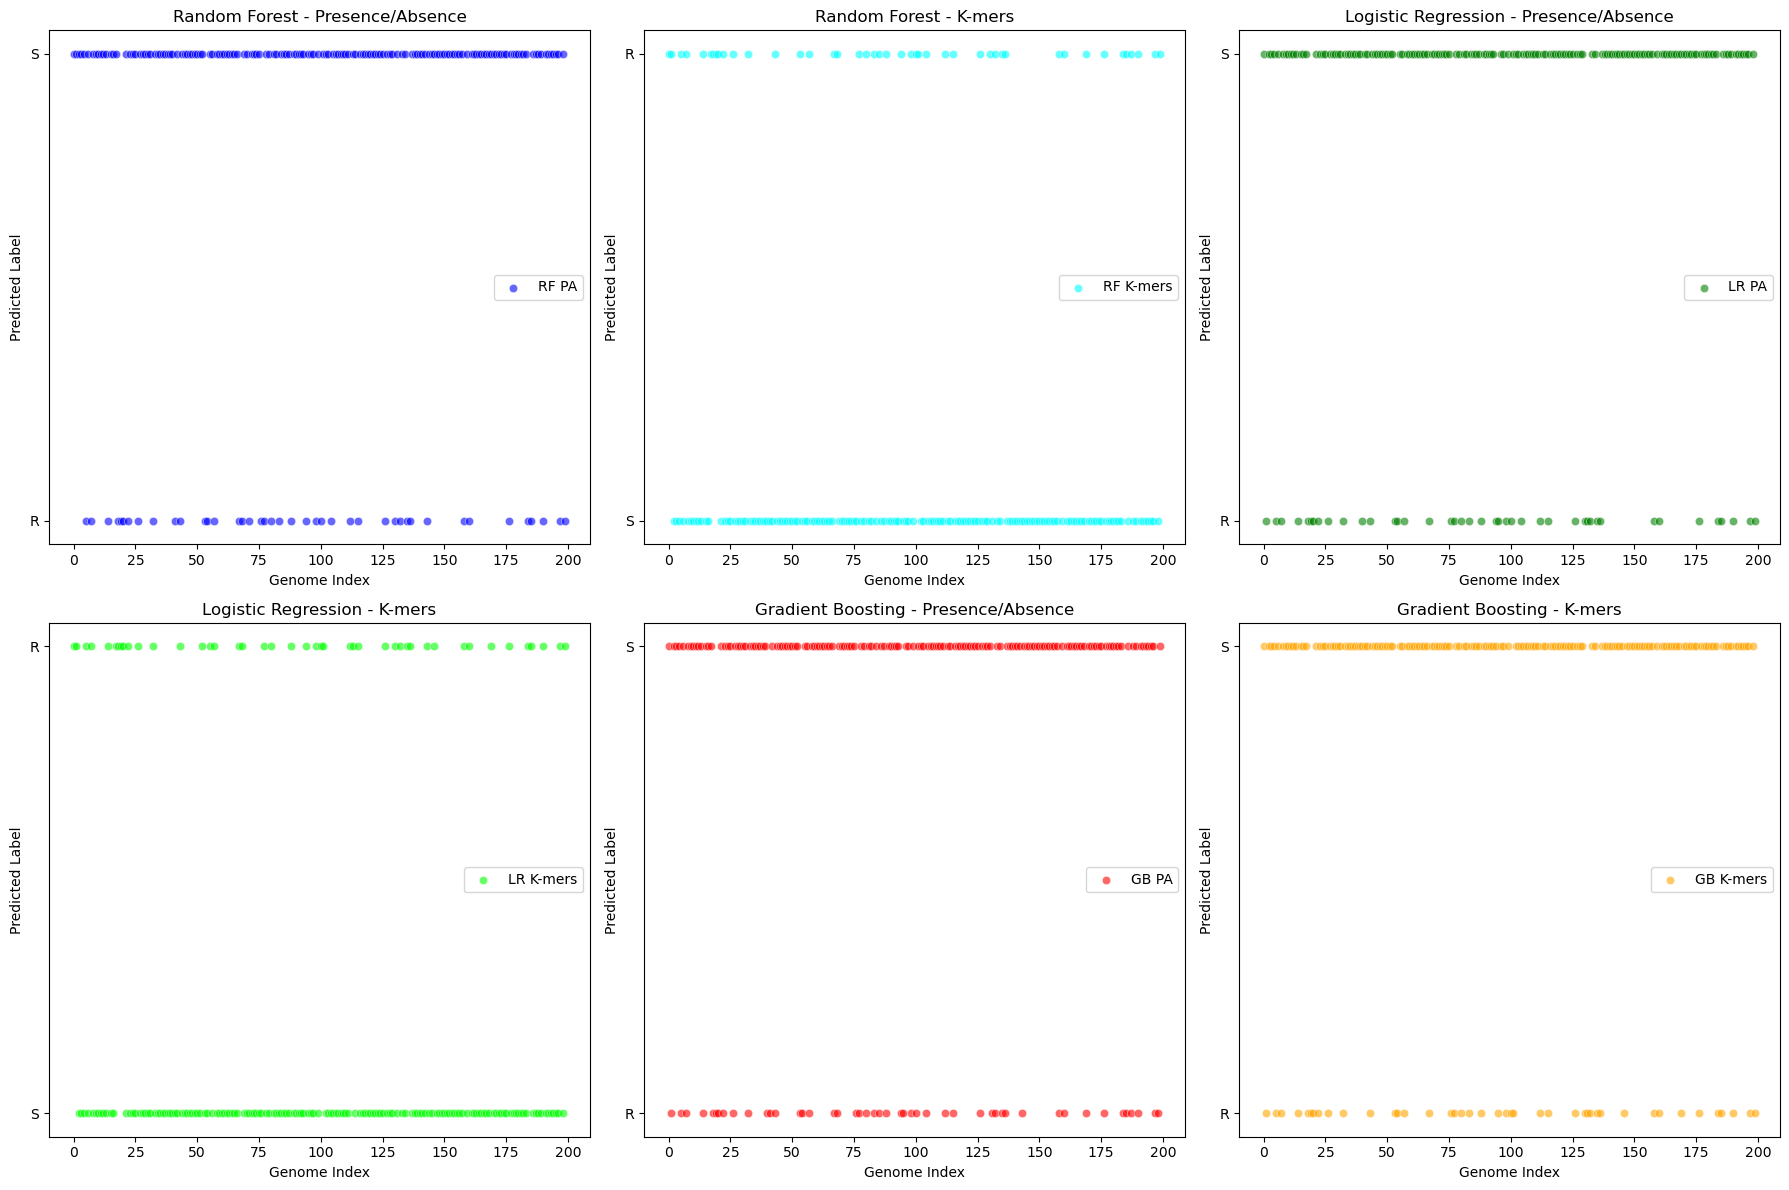

In [8]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.scatterplot(x=range(len(y_test_ids)), y=rf_predictions_pa, alpha=0.6, label='RF PA', color='blue')
plt.title('Random Forest - Presence/Absence')
plt.xlabel('Genome Index')
plt.ylabel('Predicted Label')
plt.legend()

plt.subplot(2, 3, 2)
sns.scatterplot(x=range(len(y_test_ids)), y=rf_predictions_kmer, alpha=0.6, label='RF K-mers', color='cyan')
plt.title('Random Forest - K-mers')
plt.xlabel('Genome Index')
plt.ylabel('Predicted Label')
plt.legend()

plt.subplot(2, 3, 3)
sns.scatterplot(x=range(len(y_test_ids)), y=lr_predictions_pa, alpha=0.6, label='LR PA', color='green')
plt.title('Logistic Regression - Presence/Absence')
plt.xlabel('Genome Index')
plt.ylabel('Predicted Label')
plt.legend()

plt.subplot(2, 3, 4)
sns.scatterplot(x=range(len(y_test_ids)), y=lr_predictions_kmer, alpha=0.6, label='LR K-mers', color='lime')
plt.title('Logistic Regression - K-mers')
plt.xlabel('Genome Index')
plt.ylabel('Predicted Label')
plt.legend()

plt.subplot(2, 3, 5)
sns.scatterplot(x=range(len(y_test_ids)), y=gb_predictions_pa, alpha=0.6, label='GB PA', color='red')
plt.title('Gradient Boosting - Presence/Absence')
plt.xlabel('Genome Index')
plt.ylabel('Predicted Label')
plt.legend()

plt.subplot(2, 3, 6)
sns.scatterplot(x=range(len(y_test_ids)), y=gb_predictions_kmer, alpha=0.6, label='GB K-mers', color='orange')
plt.title('Gradient Boosting - K-mers')
plt.xlabel('Genome Index')
plt.ylabel('Predicted Label')
plt.legend()

plt.tight_layout()
plt.show()

<h3>Grid Search for each feature and model</h3>
<p>Performed a grid search to optimize hyperparameters for three machine learning models- Random Forest, Logistic Regression, and Gradient Boosting- on two feature sets: Presence/Absence and K-mers. It defines parameter grids for each model, iterates through the models and feature sets, and uses GridSearchCV with 3-fold cross-validation to find the best hyperparameters based on balanced accuracy. The best scores for each model-feature set combination are stored in a dictionary and printed for comparison. This process helps identify the most effective model and feature set for predicting antibiotic resistance.</p>

In [9]:
models = {
    "RandomForest": RandomForestClassifier(random_state=seed),
    "LogisticRegression": LogisticRegression(max_iter=100, random_state=seed),
    "GradientBoosting": GradientBoostingClassifier(random_state=seed)
}

param_grids = {
    "RandomForest": {
        "n_estimators": [5, 10, 15],
        "max_depth": [5, 10, 15]
    },
    "LogisticRegression": {
        "C": [0.01, 0.1, 1, 10]
    },
    "GradientBoosting": {
        "n_estimators": [5, 10, 15],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5]
    }
}

gridsearch_scores = {}

for model_name, model in models.items():
    for feature_set_name, (X_train, X_test) in {
        "Presence/Absence": (X_train_pa, X_test_pa),
        "K-mers": (X_train_kmers, X_test_kmers)
    }.items():
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grids[model_name],
            cv=3,
            scoring="balanced_accuracy"
        )
        grid_search.fit(X_train, y_train)
        best_score = grid_search.best_score_
        gridsearch_scores[(model_name, feature_set_name)] = best_score

print("Balanced Accuracy Scores:")
for (model_name, feature_set_name), score in gridsearch_scores.items():
    print(f"Model: {model_name}, Feature Set: {feature_set_name}, Balanced Accuracy Score: {score}")

c:\Users\jhana\miniconda3\envs\etbg-env\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\jhana\miniconda3\envs\etbg-env\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Balanced Accuracy Scores:
Model: RandomForest, Feature Set: Presence/Absence, Balanced Accuracy Score: 0.7832328308207704
Model: RandomForest, Feature Set: K-mers, Balanced Accuracy Score: 0.8215284757118928
Model: LogisticRegression, Feature Set: Presence/Absence, Balanced Accuracy Score: 0.8157202680067002
Model: LogisticRegression, Feature Set: K-mers, Balanced Accuracy Score: 0.8165410385259632


<h3>Random Search for each feature and model</h3>
<p>The code performs hyperparameter optimization using RandomizedSearchCV for three machine learning models- Logistic Regression, Random Forest, and Gradient Boosting- on two feature sets: Presence/Absence and K-mers. For Logistic Regression, it tunes the regularization parameter C and the maximum number of iterations. For Random Forest, it evaluates combinations of the number of estimators and maximum tree depth. For Gradient Boosting, it optimizes the number of estimators, learning rate, and maximum depth. The code also uses K-Fold cross-validation to evaluate Random Forest performance on different splits of the data. Finally, it prints the best hyperparameters and balanced accuracy scores for each model and feature set, helping identify the most effective configurations for predicting antibiotic resistance.</p>

In [10]:
# a. Logisitc Regression
param_distributions = {
    "C": uniform(loc=0.01, scale=10),
    "max_iter": [10, 15, 20]
}

lr_random_cv_pa = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=seed),
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring=make_scorer(balanced_accuracy_score),
    random_state=seed
)
lr_random_cv_pa.fit(X_train_pa, y_train)

lr_random_cv_kmers = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=seed),
    param_distributions=param_distributions,
    n_iter=5,
    cv=3,
    scoring=make_scorer(balanced_accuracy_score),
    random_state=seed
)
lr_random_cv_kmers.fit(X_train_kmers, y_train)

c:\Users\jhana\miniconda3\envs\etbg-env\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\jhana\miniconda3\envs\etbg-env\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

RandomizedSearchCV(cv=3, estimator=LogisticRegression(random_state=130),
                   n_iter=5,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002159ECDFE20>,
                                        'max_iter': [10, 15, 20]},
                   random_state=130,
                   scoring=make_scorer(balanced_accuracy_score, response_method='predict'))

In [11]:
# b. Random Forest
K = 3
kfold = sklearn.model_selection.KFold(
    n_splits=K,
    shuffle=True,
    random_state=seed
)

kfold_dfs_pa = {}
kfold_dfs_kmers = {}
val_idx_pa = {}
val_idx_kmers = {}

for i, (train_index, val_index) in enumerate(kfold.split(X_test_pa)):
    val_idx_pa[i] = val_index
    kfold_dfs_pa[i] = (X_test_pa[train_index], X_test_pa[val_index], y_train[train_index], y_train[val_index])

for i, (train_index, val_index) in enumerate(kfold.split(X_test_kmers)):
    val_idx_kmers[i] = val_index
    kfold_dfs_kmers[i] = (X_test_kmers[train_index], X_test_kmers[val_index], y_train[train_index], y_train[val_index])

X_train_fold_0_pa = kfold_dfs_pa[0][0]
X_val_fold_0_pa = kfold_dfs_pa[0][1]
y_train_fold_0_pa = kfold_dfs_pa[0][2]
y_val_fold_0_pa = kfold_dfs_pa[0][3]

X_train_fold_0_kmers = kfold_dfs_kmers[0][0]
X_val_fold_0_kmers = kfold_dfs_kmers[0][1]
y_train_fold_0_kmers = kfold_dfs_kmers[0][2]
y_val_fold_0_kmers = kfold_dfs_kmers[0][3]

n_estimator_grid = [2, 10, 20]
max_depth_grid = [2, 5]

model_perf_pa = {}
for n_estimator in n_estimator_grid:
    for max_depth in max_depth_grid:
        cur_model = ensemble.RandomForestClassifier(n_estimators=n_estimator, max_depth=max_depth, random_state=seed)
        cur_model.fit(X_train_fold_0_pa, y_train_fold_0_pa)
        model_perf_pa[(n_estimator, max_depth)] = sklearn.metrics.balanced_accuracy_score(
            y_val_fold_0_pa, cur_model.predict(X_val_fold_0_pa)
        )

model_perf_kmers = {}
for n_estimator in n_estimator_grid:
    for max_depth in max_depth_grid:
        cur_model = ensemble.RandomForestClassifier(n_estimators=n_estimator, max_depth=max_depth, random_state=seed)
        cur_model.fit(X_train_fold_0_kmers, y_train_fold_0_kmers)
        model_perf_kmers[(n_estimator, max_depth)] = sklearn.metrics.balanced_accuracy_score(
            y_val_fold_0_kmers, cur_model.predict(X_val_fold_0_kmers)
        )

rfc_cv_pa = sklearn.model_selection.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=seed),
    param_grid={
        "n_estimators": n_estimator_grid,
        "max_depth": max_depth_grid,
    },
    cv=3,
)

rfc_cv_pa.fit(X_train_pa, y_train)

rfc_cv_kmers = sklearn.model_selection.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=seed),
    param_grid={
        "n_estimators": n_estimator_grid,
        "max_depth": max_depth_grid,
    },
    cv=3,
)

rfc_cv_kmers.fit(X_train_kmers, y_train)

n_estimator_distribution = stats.randint(low=1, high=20)
max_depth_distribution = stats.randint(low=1, high=10)

rfc_random_cv_pa = sklearn.model_selection.RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=seed),
    param_distributions={
        "n_estimators": n_estimator_distribution,
        "max_depth": max_depth_distribution,
    },
    n_iter=4,
    cv=2,
    scoring=sklearn.metrics.make_scorer(sklearn.metrics.balanced_accuracy_score),
)

rfc_random_cv_kmers = sklearn.model_selection.RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=seed),
    param_distributions={
        "n_estimators": n_estimator_distribution,
        "max_depth": max_depth_distribution,
    },
    n_iter=4,
    cv=2,
    scoring=sklearn.metrics.make_scorer(sklearn.metrics.balanced_accuracy_score),
)

rfc_random_cv_pa.fit(X_train_pa, y_train)
rfc_random_cv_kmers.fit(X_train_kmers, y_train)

RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(random_state=130),
                   n_iter=4,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002159D5E73D0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000021648197B50>},
                   scoring=make_scorer(balanced_accuracy_score, response_method='predict'))

In [ ]:
# c. Gradient Boosting
param_distributions = {
    "n_estimators": [10, 15, 20],
    "learning_rate": uniform(loc=0.01, scale=0.2),
    "max_depth": [3, 5, 7]
}

gb_random_cv_pa = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=seed),
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring=make_scorer(balanced_accuracy_score),
    random_state=seed
)
gb_random_cv_pa.fit(X_train_pa, y_train)

gb_random_cv_kmers = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=seed),
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring=make_scorer(balanced_accuracy_score),
    random_state=seed
)
gb_random_cv_kmers.fit(X_train_kmers, y_train)


In [13]:
#  Print the balanced accuracy scores for the Random Search for each model and feature set
print("Logistic Regression - Random Search:")
print("\nPresence/Absence Features:")
print("Best Parameters:", lr_random_cv_pa.best_params_)
print("Best Balanced Accuracy Score:", lr_random_cv_pa.best_score_)

print("\nK-mers Features:")
print("Best Parameters:", lr_random_cv_kmers.best_params_)
print("Best Balanced Accuracy Score:", lr_random_cv_kmers.best_score_)

print()

print("Random Forest - Random Search:")
print(f"Best Balanced Accuracy Score for Presence/Absence: {rfc_random_cv_pa.best_score_}")
print(f"Best Balanced Accuracy Score for K-mers: {rfc_random_cv_kmers.best_score_}")

print()

print("Gradient Boosting - Random Search:")
print("\nPresence/Absence Features:")
print("Best Parameters:", gb_random_cv_pa.best_params_)
print("Best Balanced Accuracy Score:", gb_random_cv_pa.best_score_)

print("\nK-mers Features:")
print("Best Parameters:", gb_random_cv_kmers.best_params_)
print("Best Balanced Accuracy Score:", gb_random_cv_kmers.best_score_)

Logistic Regression - Random Search:

Presence/Absence Features:
Best Parameters: {'C': 7.719235728723577, 'max_iter': 15}
Best Balanced Accuracy Score: 0.7948701842546063

K-mers Features:
Best Parameters: {'C': 1.426302690767407, 'max_iter': 15}
Best Balanced Accuracy Score: 0.8415452261306532

Random Forest - Random Search:
Best Balanced Accuracy Score for Presence/Absence: 0.776577480490524
Best Balanced Accuracy Score for K-mers: 0.8207134894091417



<h4>Conclusion:</h4>
According to the observed balance accuracies for each model over both features- Gene Presence/Absence and Kmers<br />
    Grid Search CV:<br />
    a. Random Forest Model over Presence/Absence feature predicted the accuracy score: <b>0.7832328308207704</b><br/>
    b. Random Forest Model over Kmers feature predicted the accuracy score: <b>0.8215284757118928</b><br/>
    c. Logistic Regression Model over Presence/Absence feature predicted the accuracy score: <b>0.8157202680067002</b><br/>
    d. Logistic Regression Model over Kmers feature predicted the accuracy score: <b>0.8165410385259632</b><br/>
    e. Gradient Boosting Model over Presence/Absence feature predicted the accuracy score: <b></b><br/>
    f. Gradient Boosting Model over Kmers feature predicted the accuracy score: <b></b><br/><br/>
    Random Search CV:<br />
    a. Random Forest Model over Presence/Absence feature predicted the accuracy score: <b>0.7948701842546063</b><br/>
    b. Random Forest Model over Kmers feature predicted the accuracy score: <b>0.8415452261306532</b><br/>
    c. Logistic Regression Model over Presence/Absence feature predicted the accuracy score: <b>0.7749386845039019</b><br/>
    d. Logistic Regression Model over Kmers feature predicted the accuracy score: <b>0.808216276477146</b><br/>
    e. Gradient Boosting Model over Presence/Absence feature predicted the accuracy score: <b></b><br/>
    f. Gradient Boosting Model over Kmers feature predicted the accuracy score: <b></b><br/><br/>
According to the accuracy report of prediction on Kaggle,<br/>
    a. Random Forest Model over Presence/Absence feature predicted the accuracy score: <b>0.86250</b><br/>
    b. Random Forest Model over Kmers feature predicted the accuracy score: <b>0.91250</b><br/>
    c. Logistic Regression Model over Presence/Absence feature predicted the accuracy score: <b>0.86250</b><br/>
    d. Logistic Regression Model over Kmers feature predicted the accuracy score: <b>0.81250</b><br/>
    e. Gradient Boosting Model over Presence/Absence feature predicted the accuracy score: <b>0.90000</b><br/>
    f. Gradient Boosting Model over Kmers feature predicted the accuracy score: <b>0.80625</b><br/><br/>
So, considering these results, we can say that the best model to Predict Antibiotic (Cefepime) Resistance in E.coli Bacteria is: <b>Random Forest Model</b> over <b>Kmers</b> feature.<br/>
<br />
<b><u>NOTE:</u></b> This was executed without gradient boosting model, because the model was using a high number CPU cores and slowing the notebook execution altogether. However, considering other parameters of comparison that did not require much processing, gradient boosting model still performed lower than Random Forest Model over both features.